# 02 Buffer generation
author: SheltonXiao (Tong Xiao)    
2023/3/13

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Load data

In [2]:
totaldf = pd.read_csv(os.path.join(r"data\forfeature",f"wellts_total.csv"),index_col=0)

In [3]:
totaldf.tail()

,Water or Steam Injected (bbl),Gas or Air Injected (Mcf),Oil Produced (bbl),Water Produced (bbl),Gas Produced (Mcf)
OID,,,,,
44,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
45,0.000000e+00,0.0,1.057610e+05,6.730200e+04,1.810270e+05
47,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
71,1.843367e+10,425460.0,9.427292e+08,1.641493e+10,2.010439e+08
72,1.243168e+09,3.0,8.190149e+07,1.648340e+09,1.947350e+07


array([[<AxesSubplot:title={'center':'Water or Steam Injected (bbl)'}>,
        <AxesSubplot:title={'center':'Gas or Air Injected (Mcf)'}>],
       [<AxesSubplot:title={'center':'Oil Produced (bbl)'}>,
        <AxesSubplot:title={'center':'Water Produced (bbl)'}>],
       [<AxesSubplot:title={'center':'Gas Produced (Mcf)'}>,
        <AxesSubplot:>]], dtype=object)

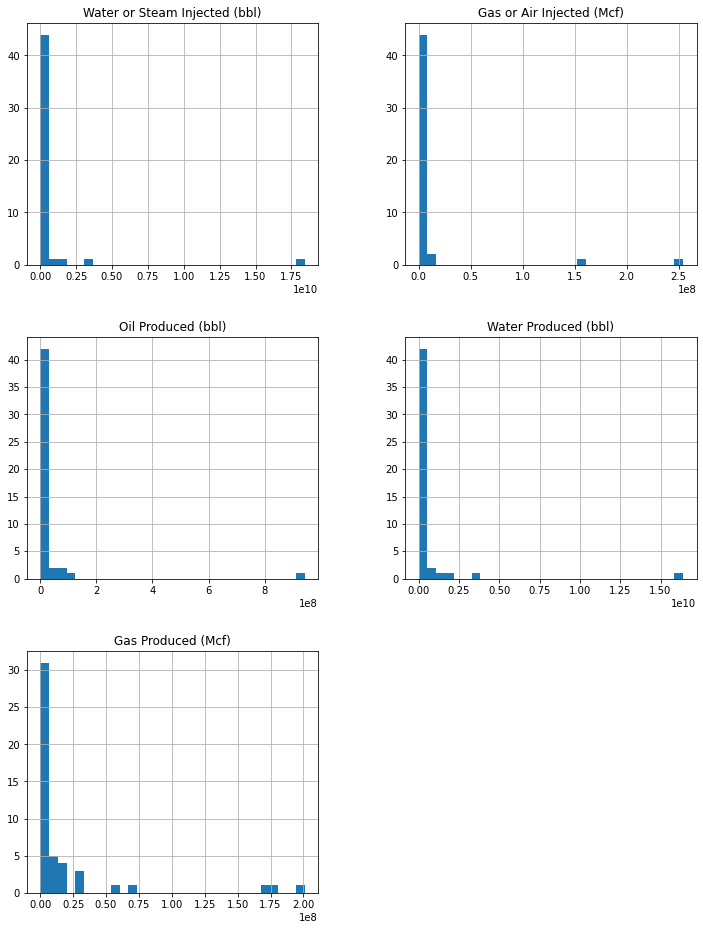

In [4]:
totaldf.hist(figsize=(12,16),bins = 30)

In [5]:
totaldf["Water"] = totaldf["Water Produced (bbl)"] - totaldf["Water or Steam Injected (bbl)"]

<AxesSubplot:xlabel='OID'>

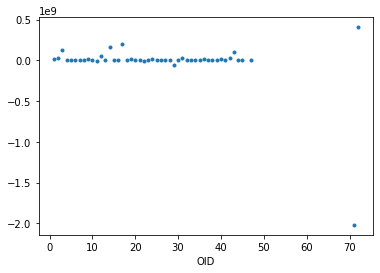

In [6]:
totaldf["Water"].plot(marker = ".",linewidth = 0)

In [7]:
totaldf["Gas"] = totaldf["Gas Produced (Mcf)"] - totaldf["Gas or Air Injected (Mcf)"]

<AxesSubplot:xlabel='OID'>

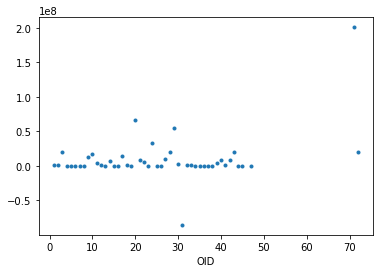

In [8]:
totaldf["Gas"].plot(marker = ".",linewidth = 0)

## Buffer definition

only focus on production, ignore injection

oil 1 bbl = 0.159 m3    
    1 bbl = 0.14 t    
water 1 bbl = 0.159 m3    
gas 1 mcf = 28.32 m3    

use heat to define the well size

oil : 1 bbl -> 5.8 * 1e6 Btu     
gas : 1 m3 -> 3.6 * 1e4 Btu   
      1 mcf -> 1.0 * 1e6 Btu     

1 bbl oil -> 5.8 mcf gas

In [9]:
totaldf["Heat Produced(Mcf)"] = 5.8 * totaldf["Gas Produced (Mcf)"] + totaldf["Oil Produced (bbl)"]

<AxesSubplot:>

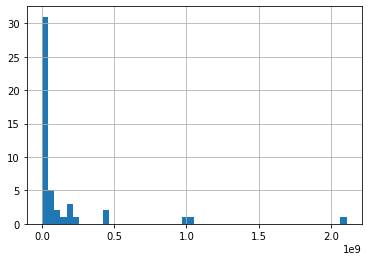

In [10]:
totaldf["Heat Produced(Mcf)"].hist(bins = 50)
#totaldf["Heat Produced(Mcf)"].plot(marker = ".",linewidth = 0)

use volume to define well size

In [11]:
totaldf["Volume Produced(m3)"] = 28.32 * totaldf["Gas Produced (Mcf)"] + 0.159 * totaldf["Water Produced (bbl)"] + 0.159 * totaldf["Oil Produced (bbl)"]

<AxesSubplot:xlabel='OID'>

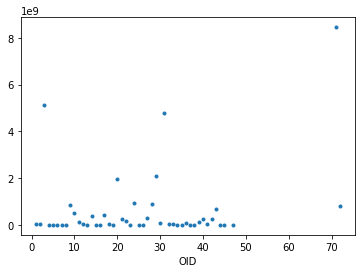

In [12]:
totaldf["Volume Produced(m3)"].plot(marker = ".",linewidth = 0)

<AxesSubplot:>

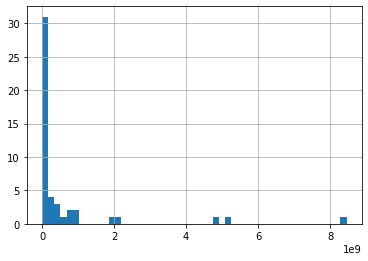

In [13]:
totaldf["Volume Produced(m3)"].hist(bins = 50)

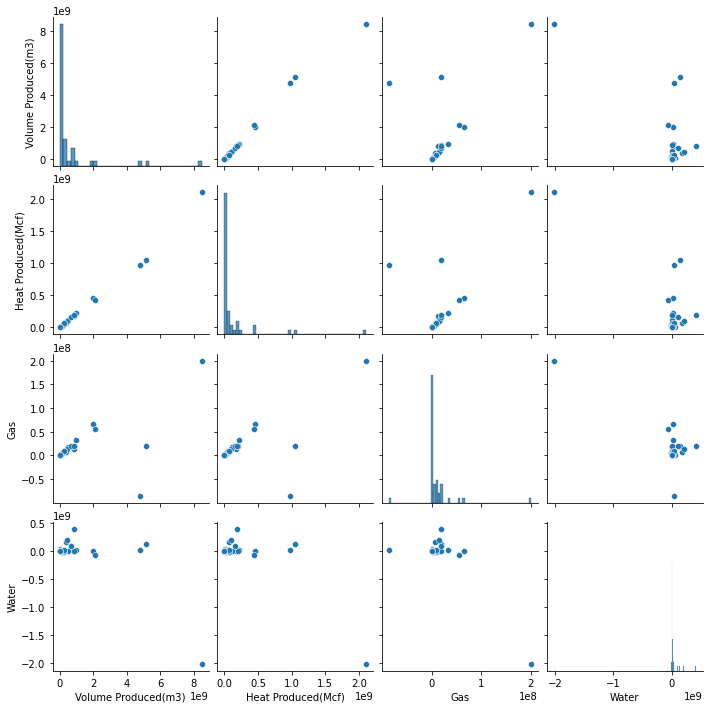

In [14]:
sns.pairplot(totaldf[["Volume Produced(m3)","Heat Produced(Mcf)","Gas","Water"]])

volume production and heat production seems high correlative     
water balance have no obvious relationship with the production

Use volume to define the size

<AxesSubplot:>

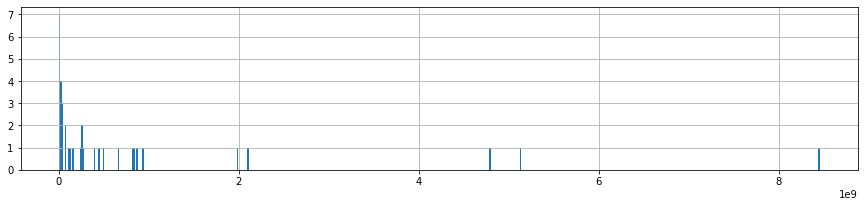

In [15]:
totaldf["Volume Produced(m3)"].loc[totaldf["Volume Produced(m3)"]!=0].hist(bins = 500,figsize=(15,3))

<AxesSubplot:>

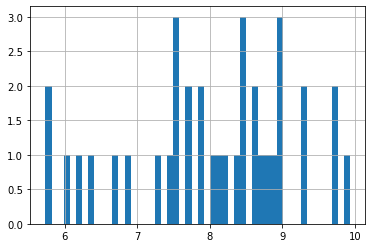

In [16]:
np.log10(totaldf["Volume Produced(m3)"].loc[totaldf["Volume Produced(m3)"]!=0]).hist(bins = 50)

### Descrete buffer

In [20]:
def visulize_buffer(df, vcol = "Volume Produced(m3)",descrete = True, 
                    dividelis = [0,5e7,5e8,1e9], bufferlis = [5,10,15,20],
                    f = f, k = 3, b = 0):
    xmin = min(0,df[vcol].min())
    xmax = df[vcol].max() + 100
    x = np.linspace(xmin,xmax,10000)
    y = np.zeros(10000)
    if descrete:
        for i in range(len(dividelis)):
            left = dividelis[i]
            try:
                right = dividelis[i+1]
            except:
                right = np.inf
            y[(x >= left) & (x < right)] = bufferlis[i]*1000
    else:
        y = f(x,k,b)

    plt.figure(figsize = (15,5))
    plt.plot(x,y)
    plt.scatter(df[vcol],df["BUFF_DIST"])
    plt.ylim(-2*1000,27*1000)
    plt.grid()


In [36]:
def descrete_buffer(df, vcol = "Volume Produced(m3)",dividelis = [0,5e7,5e8,1e9], bufferlis = [5,10,15,20]):
    assert(len(dividelis)==len(bufferlis))
    for i in range(len(dividelis)):
        left = dividelis[i]
        try:
            right = dividelis[i+1]
        except:
            right = np.inf
        df.loc[(df[vcol] >= left) & (df[vcol] < right),"BUFF_DIST"] = bufferlis[i]*1000
    return df


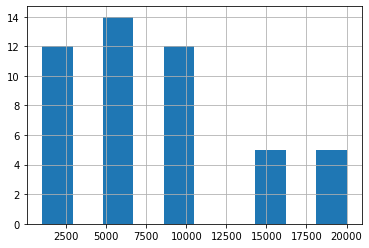

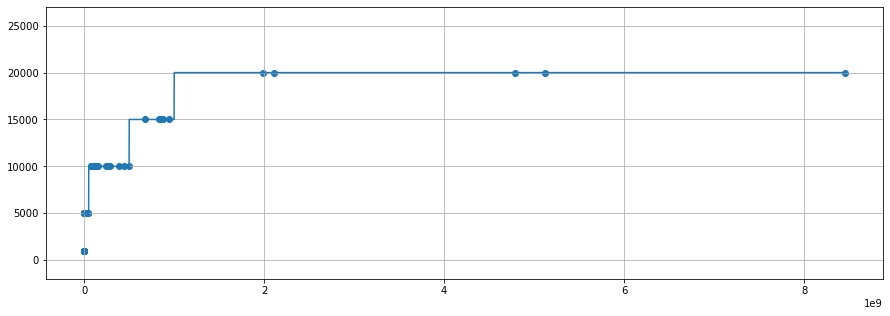

In [37]:
sli1 = totaldf[["Volume Produced(m3)"]].copy()
sli1 = descrete_buffer(sli1,dividelis = [0,10,5e7,5e8,1e9], bufferlis = [1,5,10,15,20])
sli1["BUFF_DIST"].hist()
visulize_buffer(sli1)
#sli1.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","stage_1.csv"))

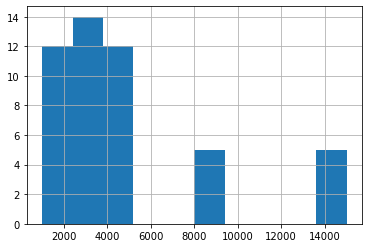

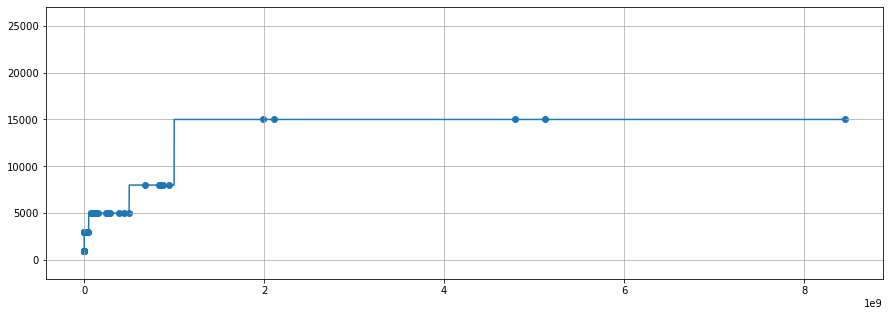

In [23]:
sli2 = totaldf[["Volume Produced(m3)"]].copy()
sli2 = descrete_buffer(sli2,dividelis = [0, 10, 5e7,5e8,1e9], bufferlis = [1,3,5,8,15])
sli2["BUFF_DIST"].hist()
visulize_buffer(sli2,dividelis = [0, 10, 5e7,5e8,1e9], bufferlis = [1,3,5,8,15])
#sli2.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","stage_2.csv"))

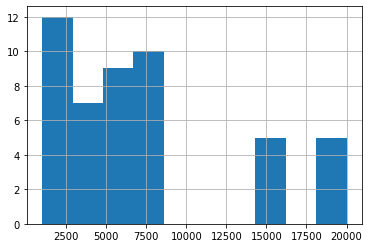

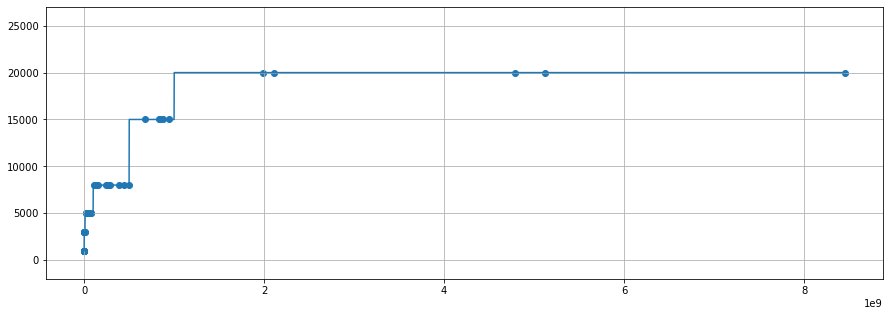

In [24]:
sli3 = totaldf[["Volume Produced(m3)"]].copy()
sli3 = descrete_buffer(sli3,dividelis = [0, 10, 1e7,1e8,5e8,1e9], bufferlis = [1,3,5,8,15,20])
sli3["BUFF_DIST"].hist()
visulize_buffer(sli3,dividelis = [0, 10, 1e7,1e8,5e8,1e9], bufferlis = [1,3,5,8,15,20])
#sli3.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","stage_3.csv"))

### Continuous buffer

In [18]:
def f(x,k,b):
    return (k*np.log10(x)+b)*1000

In [19]:
def f2(x,k,b):
    return (k*x+b)*1000

In [45]:
def continuous_buffer(df,vcol = "Volume Produced(m3)", f = f, k = 1, b = 0):
    df["BUFF_DIST"]= f(df[vcol].loc[df[vcol]!=0] ,k,b)
    df = df.fillna(1*1000)
    return df

C:\Users\Intel\AppData\Local\Temp\ipykernel_19100\1615199958.py:2: RuntimeWarning: divide by zero encountered in log10
  return (k*np.log10(x)+b)*1000


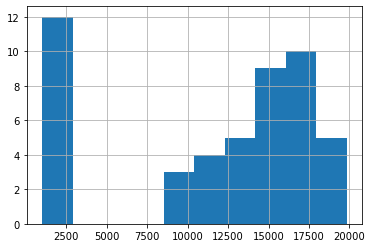

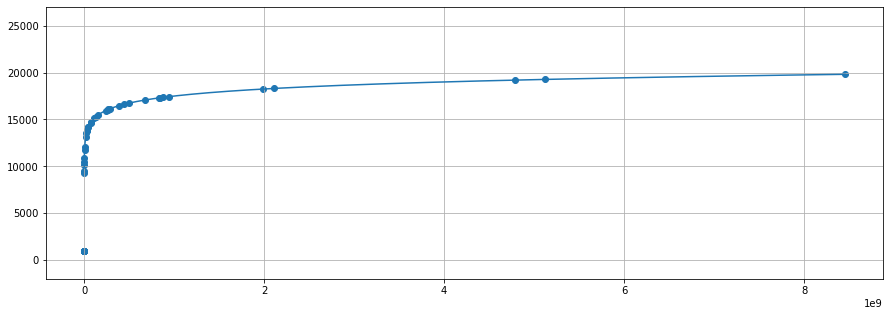

In [46]:
sli4 = totaldf[["Volume Produced(m3)"]].copy()
sli4 = continuous_buffer(sli4,k=2.5,b=-5)
sli4["BUFF_DIST"].hist()
visulize_buffer(sli4,descrete=False,k=2.5,b=-5)
#sli4.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","log_1.csv"))

C:\Users\Intel\AppData\Local\Temp\ipykernel_19100\1615199958.py:2: RuntimeWarning: divide by zero encountered in log10
  return (k*np.log10(x)+b)*1000


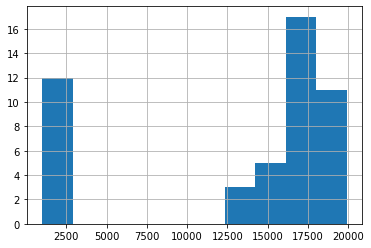

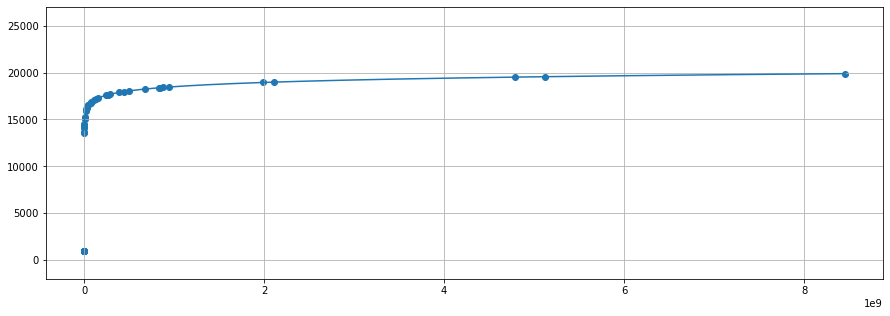

In [47]:
sli5 = totaldf[["Volume Produced(m3)"]].copy()
sli5 = continuous_buffer(sli5,k=1.5,b=5)
sli5["BUFF_DIST"].hist()
visulize_buffer(sli5,descrete=False,k=1.5,b=5)
#sli5.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","log_2.csv"))

C:\Users\Intel\AppData\Local\Temp\ipykernel_19100\1615199958.py:2: RuntimeWarning: divide by zero encountered in log10
  return (k*np.log10(x)+b)*1000


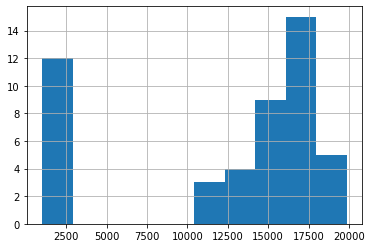

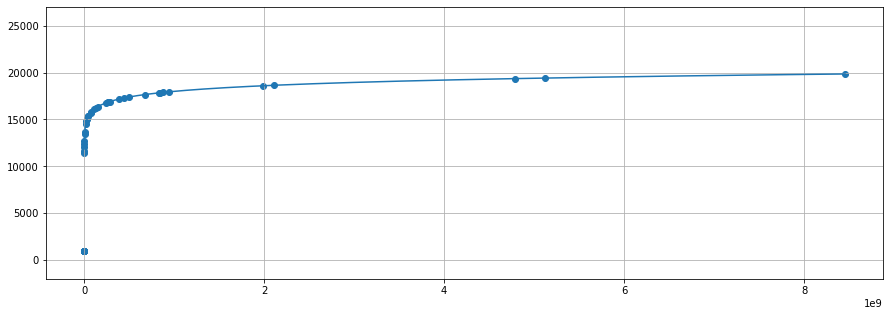

In [48]:
sli6 = totaldf[["Volume Produced(m3)"]].copy()
sli6 = continuous_buffer(sli6,k=2,b=0)
sli6["BUFF_DIST"].hist()
visulize_buffer(sli6,descrete=False,k=2,b=0)
#sli6.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","log_3.csv"))

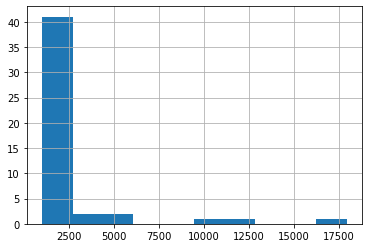

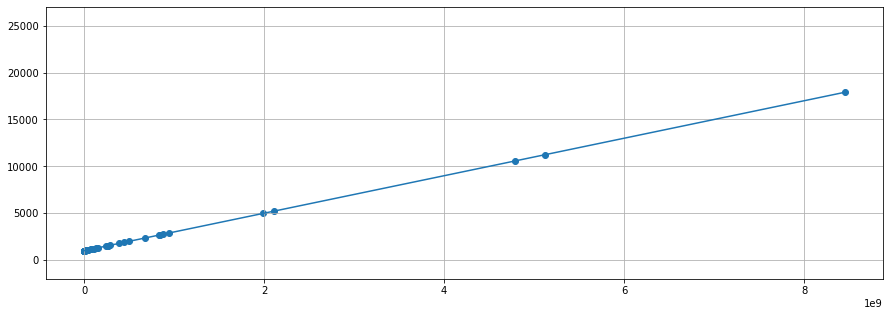

In [49]:
sli7 = totaldf[["Volume Produced(m3)"]].copy()
sli7 = continuous_buffer(sli7,f = f2,k=2*1e-9,b=1)
sli7["BUFF_DIST"].hist()
visulize_buffer(sli7,descrete=False,f=f2,k=2*1e-9,b=1)
#sli7.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","linear_1.csv"))

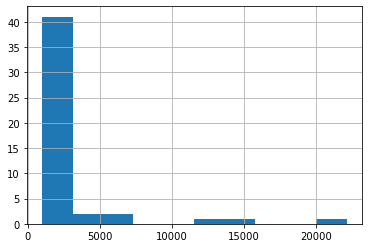

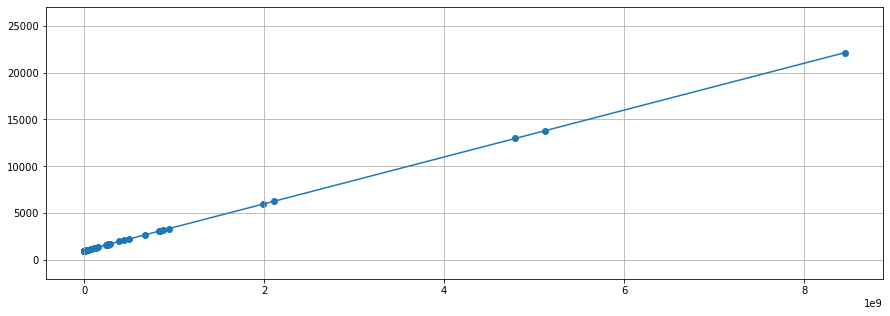

In [50]:
sli8 = totaldf[["Volume Produced(m3)"]].copy()
sli8 = continuous_buffer(sli8,f = f2,k=2.5*1e-9,b=1)
sli8["BUFF_DIST"].hist()
visulize_buffer(sli8,descrete=False,f=f2,k=2.5*1e-9,b=1)
#sli8.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","linear_2.csv"))

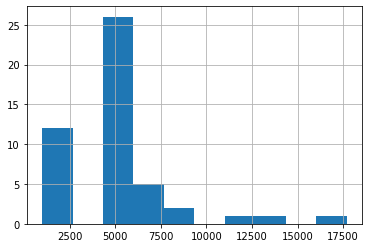

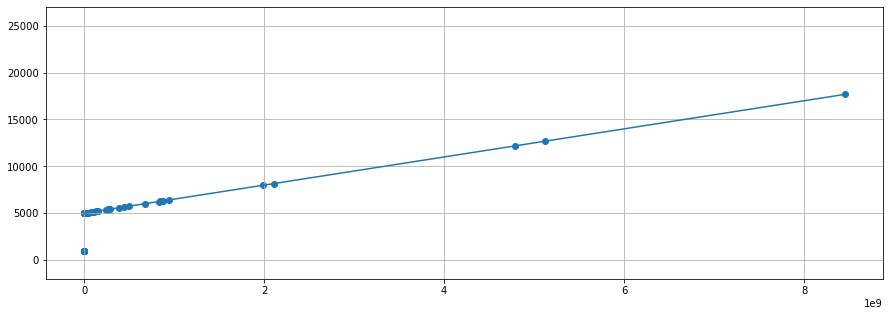

In [51]:
sli9 = totaldf[["Volume Produced(m3)"]].copy()
sli9 = continuous_buffer(sli9,f = f2,k=1.5*1e-9,b=5)
sli9["BUFF_DIST"].hist()
visulize_buffer(sli9,descrete=False,f=f2,k=1.5*1e-9,b=5)
#sli9.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","linear_3.csv"))

### Result combinition

In [54]:
sli = pd.DataFrame(index = sli1.index)
sli["step_1"] = sli1["BUFF_DIST"]
sli["step_2"] = sli2["BUFF_DIST"]
sli["step_3"] = sli3["BUFF_DIST"]
sli["log_1"] = sli4["BUFF_DIST"]
sli["log_2"] = sli5["BUFF_DIST"]
sli["log_3"] = sli6["BUFF_DIST"]
sli["linear_1"] = sli7["BUFF_DIST"]
sli["linear_2"] = sli8["BUFF_DIST"]
sli["linear_3"] = sli9["BUFF_DIST"]

In [55]:
sli

,step_1,step_2,step_3,log_1,log_2,log_3,linear_1,linear_2,linear_3
OID,,,,,,,,,
1,5000.0,3000.0,5000.0,13150.283153,15890.169892,14520.226523,1036.403510,1045.504387,5027.302632
2,5000.0,3000.0,5000.0,14187.878204,16512.726922,15350.302563,1094.663221,1118.329026,5070.997416
3,20000.0,15000.0,20000.0,19274.393717,19564.636230,19419.514973,11251.501563,13814.376954,12688.626173
4,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
5,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
6,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
7,5000.0,3000.0,3000.0,10091.043072,14054.625843,12072.834457,1002.174940,1002.718675,5001.631205
8,1000.0,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
9,15000.0,8000.0,15000.0,17311.613631,18386.968179,17849.290905,2681.417055,3101.771318,6261.062791


In [56]:
sli.to_csv(os.path.join(r"data/forfeature/BUFF_DIST","buffer_dist.csv"))